# Membership Inference over Diffusion-models-based Synthetic Tabular Data (MIDST) Challenge @ SaTML 2025.

## White Box Single Table Competition
Welcome to the MIDST challenge!

The MIDST challenge is a multi-track competition aiming to quantitatively evaluate the privacy of synthetic tabular data generated by diffusion models, with a specific focus on its resistance to membership inference attacks (MIAs).

This competition focuses on White Box MIA on tabular diffusion models trained on a single table transaction dataset. The schema of the transaction dataset is as follows:
| trans_id | account_id | trans_date | trans_type | operation | amount  | balance  | k_symbol | bank | account |
|----------|------------|------------|------------|-----------|---------|----------|----------|------|---------|
| integer  | integer    | integer    | integer    | integer   | float   | float    | integer  | integer | integer |

MIA will be performed over two state-of-the-art methods [TabSyn](https://arxiv.org/pdf/2310.09656) and [TabDDPM](https://arxiv.org/pdf/2209.15421). A collection of TabSyn and TabDDPM models will be trained on random subsets of the transaction dataset. The goal is to create an approach (MIA) that can distinguish between samples used to train a model (train data) and other data randomly sampled from the transaction dataset (holdout data) given the model and it's output synthetic data. The `final` set includes 20 models, each with its own set of challenge points (ie train and holdout data), to evaluate solutions on. To facilitate designing an attack, 30 `train` models are provided with comprehensive information about the model, training data and output synthetic data. Additionally, 20 `dev` models are provided to assist in evaluating the effectiveness of attacks prior to making a final submission to the `final` set. Participants can choose to perform MIA over one of or both TabSyn and TabDDPM. In the case of both, the attack that obtains the highest score will be used to rank the submission. A high level summary of the competition is below:
![wbox_diagram_final](https://github.com/user-attachments/assets/2ebb5eed-a6e3-433a-8769-4310b7fbc822)

This notebook will walk you through the process of creating and packaging a submission to the white box single table challenge.

In [1]:
%cd ..

c:\Users\ksush\attacks\MIDSTModels


C:\Users\ksush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json

from midst_models.single_table_TabDDPM.complex_pipeline import (
    clava_clustering,
    clava_training,
    clava_load_pretrained,
    clava_synthesizing,
    load_configs,
)
from midst_models.single_table_TabDDPM.pipeline_modules import load_multi_table
from midst_models.single_table_TabDDPM.complex_pipeline import tabddpm_whitebox_load_pretrained

In [3]:
import os
import zipfile
import pandas as pd
import numpy as np
import re

### GENERATE DATA

In [4]:
train_w_id_df = pd.read_csv("tabddpm_white_box/train/tabddpm_1/challenge_with_id.csv")
train_df = train_w_id_df.iloc[:, 2:]
train_df.to_csv("tabddpm_white_box/train/tabddpm_1/challenge.csv", index=False)

In [5]:
path = "tabddpm_white_box/train/tabddpm_1"
model = tabddpm_whitebox_load_pretrained(path)

# Load config
config_path = "tabddpm_white_box/train/tabddpm_1/trans.json"
configs, save_dir = load_configs(config_path)

# Display config
json_str = json.dumps(configs, indent=4)
print(json_str)

# Load  dataset
# In this step, we load the dataset according to the 'dataset_meta.json' file located in the data_dir.

tables, relation_order, dataset_meta = load_multi_table(path, train_data="challenge")

# Tables is a dictionary of the multi-table dataset
print(
    "{} We show the keys of the tables dictionary below {}".format("=" * 20, "=" * 20)
)
print(list(tables.keys()))

# Display important clustering parameters
params_clustering = configs["clustering"]
print("{} We show the clustering parameters below {}".format("=" * 20, "=" * 20))
for key, val in params_clustering.items():
    print(f"{key}: {val}")
print("")

# Clustering on the multi-table dataset
tables, all_group_lengths_prob_dicts = clava_clustering(
    tables, relation_order, save_dir, configs
)



Checkpoint found, loading...
{
    "general": {
        "data_dir": "/projects/aieng/midst_competition/data/tabddpm/tabddpm_1",
        "exp_name": "train_1",
        "workspace_dir": "/projects/aieng/midst_competition/data/tabddpm/tabddpm_1/workspace",
        "sample_prefix": "",
        "test_data_dir": "/projects/aieng/midst_competition/data/tabddpm/tabddpm_1"
    },
    "clustering": {
        "parent_scale": 1.0,
        "num_clusters": 50,
        "clustering_method": "both"
    },
    "diffusion": {
        "d_layers": [
            512,
            1024,
            1024,
            1024,
            1024,
            512
        ],
        "dropout": 0.0,
        "num_timesteps": 2000,
        "model_type": "mlp",
        "iterations": 200000,
        "batch_size": 4096,
        "lr": 0.0006,
        "gaussian_loss_type": "mse",
        "weight_decay": 1e-05,
        "scheduler": "cosine"
    },
    "classifier": {
        "d_layers": [
            128,
            256,
    

C:\Users\ksush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator LabelEncoder from version 1.5.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

C:\Users\ksush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator QuantileTransformer from version 1.5.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

c:\Users\ksush\attacks\MIDSTModels\midst_models

In [ ]:
# Generate synthetic data from scratch
cleaned_tables, synthesizing_time_spent, matching_time_spent = clava_synthesizing(
    tables,
    relation_order,
    save_dir,
    all_group_lengths_prob_dicts,
    model,
    configs,
    # sample_scale=1 if "debug" not in configs else configs["debug"]["sample_scale"],
    sample_scale=0.1,
)

Generating None -> trans
Sample size: 2000


In [11]:
import torch
saved_outputs = torch.load("saved_outputs_0_200.pth")

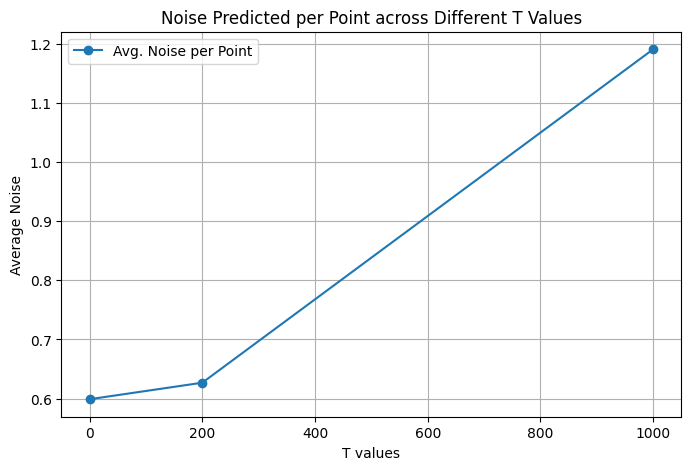

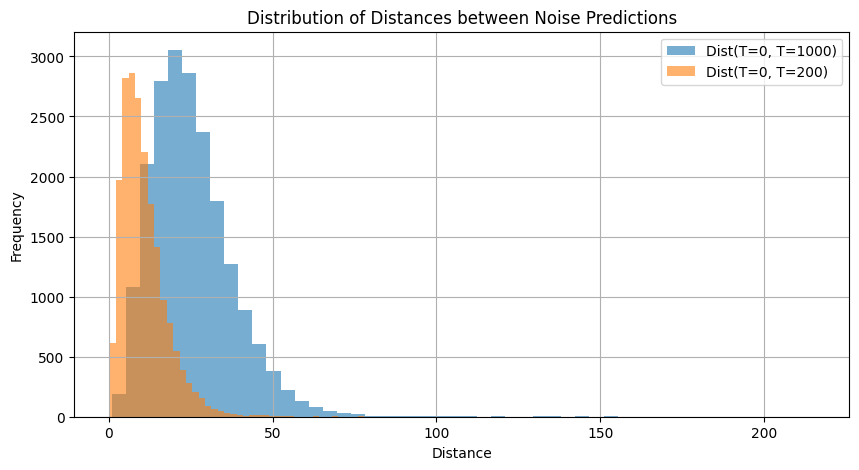

In [ ]:
import matplotlib.pyplot as plt

# Sample distance function
def distance(x0, x1, lp=2):
    return ((x0 - x1).abs()**lp).flatten(1).sum(dim=-1)


# Graph A: Amount of noise predicted per point at different values of T
x_values = sorted(saved_outputs.keys())
y_values = [saved_outputs[t].abs().mean(dim=1).mean().item() for t in x_values]

plt.figure(figsize=(8, 5))
plt.plot(x_values, y_values, marker='o', linestyle='-', label='Avg. Noise per Point')
plt.xlabel("T values")
plt.ylabel("Average Noise")
plt.title("Noise Predicted per Point across Different T Values")
plt.legend()
plt.grid()
plt.show()

# Graph B: Distance between T=0 & T=1000 and T=0 & T=200
dist_0_1000 = distance(saved_outputs[0], saved_outputs[1000])
dist_0_200 = distance(saved_outputs[0], saved_outputs[200])

plt.figure(figsize=(10, 5))
plt.hist(dist_0_1000.numpy(), bins=50, alpha=0.6, label='Dist(T=0, T=1000)')
plt.hist(dist_0_200.numpy(), bins=50, alpha=0.6, label='Dist(T=0, T=200)')
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Distances between Noise Predictions")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import torch
saved_outputs = torch.load("saved_outputs_0_200_1000.pth")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Distance function
def distance(x0, x1, lp=2):
    return ((x0 - x1).abs()**lp).flatten(1).sum(dim=-1)
label_df = pd.read_csv("tabddpm_white_box/train/tabddpm_1/challenge_label.csv")

# Assume saved_outputs is your dictionary with noise tensors
# Assume label_df is a DataFrame with one column containing 1 (member) or 0 (non-member)
labels = label_df.iloc[:, 0].values  # Convert to numpy array

# Separate members and non-members
members = labels == 1
non_members = labels == 0

# Plot noise magnitude per point for different T values
plt.figure(figsize=(10, 6))
for T, noise in saved_outputs.items():
    noise_magnitude = noise.norm(dim=1)  # Compute magnitude of noise per point
    plt.plot([T] * len(noise_magnitude[members]), noise_magnitude[members], 'bo', alpha=0.02, label='Members' if T == 0 else "")
    plt.plot([T] * len(noise_magnitude[non_members]), noise_magnitude[non_members], 'ro', alpha=0.02, label='Non-Members' if T == 0 else "")

plt.xlabel("T values")
plt.ylabel("Noise Magnitude")
plt.title("Noise Magnitude per Point Over Different T values")
plt.legend()
plt.show()

# Compute distances for T = 0 vs 1000 and T = 0 vs 200
distances_0_1000 = distance(saved_outputs[0], saved_outputs[1000])
distances_0_200 = distance(saved_outputs[0], saved_outputs[200])

# Separate distances for members and non-members
dist_0_1000_members = distances_0_1000[members]
dist_0_1000_non_members = distances_0_1000[non_members]

dist_0_200_members = distances_0_200[members]
dist_0_200_non_members = distances_0_200[non_members]

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(dist_0_1000_members, bins=50, alpha=0.6, color='b', label="Members")
axes[0].hist(dist_0_1000_non_members, bins=50, alpha=0.6, color='r', label="Non-Members")
axes[0].set_title("Distance between T=0 and T=1000")
axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].hist(dist_0_200_members, bins=50, alpha=0.6, color='b', label="Members")
axes[1].hist(dist_0_200_non_members, bins=50, alpha=0.6, color='r', label="Non-Members")
axes[1].set_title("Distance between T=0 and T=200")
axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()


## Package Imports and Evironment Setup

Ensure that you have installed the proper dependenices to run the notebook. The environment installation instructions are available [here](https://github.com/VectorInstitute/MIDSTModels/tree/main/starter_kits). Now that we have verfied we have the proper packages installed, lets import them and define global variables:

In [1]:
import csv
import os
import random
import zipfile

from pathlib import Path
from functools import partial
from typing import Callable, Any

import numpy as np
import torch

from tqdm.notebook import tqdm
from data import get_challenge_points, get_challenge_labels
from metrics import get_tpr_at_fpr



In [2]:
%cd ..

c:\Users\ksush\attacks\MIDSTModels


C:\Users\ksush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
TABDDPM_DATA_DIR = "tabddpm_white_box"
TABSYN_DATA_DIR = "tabsyn_white_box"

In [5]:

def get_FLAGS():
    def FLAGS(x): return x
    FLAGS.T = 5000
    FLAGS.ch = 128
    FLAGS.ch_mult = [1, 2, 2, 2]
    FLAGS.attn = [1]
    FLAGS.num_res_blocks = 2
    FLAGS.dropout = 0.1
    FLAGS.beta_1 = 0.001
    FLAGS.beta_T = 0.2

    return FLAGS

FLAGS = get_FLAGS()


In [6]:
accumulated_df = pd.DataFrame(columns=['average_distance', 'label'])


In [10]:
import torch
import numpy as np
import logging
import csv
import os
from typing import Dict, Type
import seaborn as sns
from torch.nn.functional import normalize
import midst_models.attack.components as components
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class EpsGetter(components.EpsGetter):
    def __call__(self, xt: torch.Tensor, condition: torch.Tensor = None, noise_level=None, t: int = None) -> torch.Tensor:
        # Access the diffusion model from the dictionary structure
        model = self.model[(None, 'trans')]['diffusion']

        t = torch.ones([xt.shape[0]], device=xt.device).long() * t
        return model._denoise_fn(xt, timesteps=t)

ATTACKERS: Dict[str, Type[components.DDIMAttacker]] = {
    "PIA": components.PIA,
    "PIAN": components.PIAN,
}


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


def attack(base_dir, attacker_name="PIA", attack_num=30, interval=10, lp=3):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    # logger.addHandler(RichHandler())

    logger.info("loading the attacked model...")

    # Initialize attacker
    phases = ["train"]
    # phases = ["dev", "final"]
    
    logger.info("attack start...")
    for phase in phases:
        root = os.path.join(base_dir, phase)
        for model_folder in sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])):
            path = os.path.join(root, model_folder)
            if "30" not in str(path):
                continue

            model = tabddpm_whitebox_load_pretrained(path)
            attacker = ATTACKERS[attacker_name](
                torch.from_numpy(np.linspace(FLAGS.beta_1, FLAGS.beta_T, FLAGS.T)).to(DEVICE), interval, attack_num, EpsGetter(model), lp=lp)

            challenge_points = get_challenge_points(path)
            challenge_labels = get_challenge_labels(path)
            raw_predictions = torch.stack([attacker(cp.to(DEVICE).float()) for cp in challenge_points])
            raw_predictions_means = raw_predictions.mean(dim=1).cpu().detach().numpy()
            challenge_labels_np = challenge_labels.values.squeeze()

            non_member_distances = raw_predictions_means[challenge_labels_np == 0]
            member_distances = raw_predictions_means[challenge_labels_np == 1]

            # Create figure with three subplots
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), height_ratios=[1, 1, 1.5])
            
            # Plot 1: Full distribution
            bins = np.linspace(min(raw_predictions_means), max(raw_predictions_means), 30)
            ax1.hist(non_member_distances, bins=bins, alpha=0.6, 
                    label=f'Non-member (n={len(non_member_distances)})', 
                    color='blue')
            ax1.hist(member_distances, bins=bins, alpha=0.6,
                    label=f'Member (n={len(member_distances)})', 
                    color='red')
            
            ax1.set_xlabel('Distance')
            ax1.set_ylabel('Count')
            ax1.set_title('Full Distribution of Distances')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # First zoom: Find the densest region
            all_data = np.concatenate([member_distances, non_member_distances])
            Q1 = np.percentile(all_data, 25)
            Q3 = np.percentile(all_data, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 0.5 * IQR
            upper_bound = Q3 + 0.5 * IQR

            # Filter data for first zoom
            non_member_filtered = non_member_distances[
                (non_member_distances >= lower_bound) & 
                (non_member_distances <= upper_bound)
            ]
            member_filtered = member_distances[
                (member_distances >= lower_bound) & 
                (member_distances <= upper_bound)
            ]

            # Plot 2: First zoom level
            detailed_bins = np.linspace(lower_bound, upper_bound, 50)
            ax2.hist(non_member_filtered, bins=detailed_bins, alpha=0.6,
                    label=f'Non-member (n={len(non_member_filtered)})', 
                    color='blue')
            ax2.hist(member_filtered, bins=detailed_bins, alpha=0.6,
                    label=f'Member (n={len(member_filtered)})', 
                    color='red')
            
            ax2.set_xlabel('Distance')
            ax2.set_ylabel('Count')
            ax2.set_title('First Zoom Level\n'
                        f'(Range: {lower_bound:.2f} to {upper_bound:.2f})')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            # Second zoom: Find the even denser region
            filtered_data = np.concatenate([member_filtered, non_member_filtered])
            Q1_filtered = np.percentile(filtered_data, 25)
            Q3_filtered = np.percentile(filtered_data, 75)
            IQR_filtered = Q3_filtered - Q1_filtered
            lower_bound_filtered = Q1_filtered - 0.25 * IQR_filtered  # Using tighter bounds
            upper_bound_filtered = Q3_filtered + 0.25 * IQR_filtered

            # Filter data for second zoom
            non_member_filtered_2 = non_member_filtered[
                (non_member_filtered >= lower_bound_filtered) & 
                (non_member_filtered <= upper_bound_filtered)
            ]
            member_filtered_2 = member_filtered[
                (member_filtered >= lower_bound_filtered) & 
                (member_filtered <= upper_bound_filtered)
            ]

            # Plot 3: Second zoom level with very fine bins
            very_detailed_bins = np.linspace(lower_bound_filtered, upper_bound_filtered, 100)
            ax3.hist(non_member_filtered_2, bins=very_detailed_bins, alpha=0.6,
                    label=f'Non-member (n={len(non_member_filtered_2)})', 
                    color='blue')
            ax3.hist(member_filtered_2, bins=very_detailed_bins, alpha=0.6,
                    label=f'Member (n={len(member_filtered_2)})', 
                    color='red')
            
            ax3.set_xlabel('Distance')
            ax3.set_ylabel('Count')
            ax3.set_title('Second Zoom Level (Finest Detail)\n'
                        f'(Range: {lower_bound_filtered:.2f} to {upper_bound_filtered:.2f})')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

            # Add statistical information for the finest zoom level
            stats_text = (
                f'Dense Region Stats:\n'
                f'Non-member:\n'
                f'  Mean: {np.mean(non_member_filtered_2):.3f}\n'
                f'  Std: {np.std(non_member_filtered_2):.3f}\n'
                f'Member:\n'
                f'  Mean: {np.mean(member_filtered_2):.3f}\n'
                f'  Std: {np.std(member_filtered_2):.3f}'
            )
            ax3.text(0.02, 0.98, stats_text, 
                    transform=ax3.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            plt.tight_layout()
            plt.savefig(os.path.join(path, f"distance_distribution_T={interval}_lp={lp}.png"), dpi=300, bbox_inches='tight')
            plt.close()

            # Save detailed statistics for all zoom levels
            stats_summary = pd.DataFrame({
                'Metric': ['Full Mean', 'Full Std', 
                        'First Zoom Mean', 'First Zoom Std',
                        'Second Zoom Mean', 'Second Zoom Std',
                        'Points in Densest Region', 'Total Points'],
                'Member': [
                    member_distances.mean(),
                    member_distances.std(),
                    member_filtered.mean(),
                    member_filtered.std(),
                    member_filtered_2.mean(),
                    member_filtered_2.std(),
                    len(member_filtered_2),
                    len(member_distances)
                ],
                'Non-member': [
                    non_member_distances.mean(),
                    non_member_distances.std(),
                    non_member_filtered.mean(),
                    non_member_filtered.std(),
                    non_member_filtered_2.mean(),
                    non_member_filtered_2.std(),
                    len(non_member_filtered_2),
                    len(non_member_distances)
                ]
            })
            
            stats_summary.to_csv(os.path.join(path, f"detailed_statistics_T={interval}_lp={lp}.csv"), index=False)

            # Continue with the original prediction code
            normalized_preds = []
            for pred_batch in raw_predictions:
                binary_preds = (pred_batch <= 1000000).float()
                normalized_preds.append(binary_preds)

            final_predictions = torch.stack(normalized_preds)
            predictions_cpu = final_predictions.cpu().detach().numpy()

            with open(os.path.join(path, "prediction.csv"), mode="w", newline="") as file:
                writer = csv.writer(file)
                for value in predictions_cpu.squeeze():
                    writer.writerow([value])



In [19]:
attack(base_dir="tabddpm_white_box",
        attacker_name="PIAN",
        attack_num=3,
        interval=200,
        lp=4)

Checkpoint found, loading...


C:\Users\ksush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator LabelEncoder from version 1.5.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

C:\Users\ksush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator QuantileTransformer from version 1.5.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

C:\Users\ksush\AppData\Local\Packages\PythonSof

## Scoring

Let's see how the attack does on `train`, for which we have the ground truth.
When preparing a submission, you can use part of `train` to develop an attack and a held-out part to evaluate your attack.

In [9]:
import numpy as np
from sklearn.metrics import roc_auc_score
import os
from typing import List, Tuple

def safe_load_data(filepath: str, is_prediction: bool = True) -> np.ndarray:
    """
    Safely load data from CSV files with error handling and debugging.
    
    Args:
        filepath: Path to the CSV file
        is_prediction: Whether this is a prediction file (True) or label file (False)
    
    Returns:
        numpy.ndarray: Loaded and validated data
    """
    try:
        if is_prediction:
            # Read the file line by line and parse each array
            predictions = []
            with open(filepath, 'r') as f:
                for line in f:
                    # Remove brackets and split by spaces
                    clean_line = line.strip().replace('[', '').replace(']', '')
                    # Convert space-separated strings to floats
                    row = np.array([float(x) for x in clean_line.split()])
                    predictions.append(row)
            return np.array(predictions)
        else:
            # For label files, skip header and use numpy
            return np.loadtxt(filepath, skiprows=1)
            
    except Exception as e:
        print(f"Error loading {filepath}: {str(e)}")
        print(f"File contents (first few lines):")
        with open(filepath, 'r') as f:
            print(f.read(500))
        raise

def get_tpr_at_fpr(y_true: np.ndarray, y_score: np.ndarray, target_fpr: float = 0.1) -> float:
    """Calculate TPR at a specific FPR threshold."""
    # Input validation
    if not isinstance(y_true, np.ndarray) or not isinstance(y_score, np.ndarray):
        raise TypeError("Inputs must be numpy arrays")
    if y_true.shape != y_score.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape} != y_score {y_score.shape}")
    
    # Sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    
    n_neg = np.sum(y_true == 0)
    n_pos = np.sum(y_true == 1)
    
    # Handle edge cases
    if n_neg == 0 or n_pos == 0:
        print("Warning: Found no positive or negative samples")
        return 0.0
        
    tpr = np.cumsum(y_true) / n_pos
    fpr = np.cumsum(1 - y_true) / n_neg
    
    for i in range(len(fpr)):
        if fpr[i] >= target_fpr:
            return tpr[i]
    return 1.0

def evaluate_membership_inference(base_dirs: List[str]) -> Tuple[float, float]:
    """
    Evaluate membership inference attack results across multiple directories.
    
    Args:
        base_dirs: List of base directories containing prediction files
        
    Returns:
        tuple: (best_tpr_at_fpr, best_auc)
    """
    tpr_at_fpr_list = []
    auc_list = []
    
    for base_dir in base_dirs:
        predictions = []
        solutions = []
        root = os.path.join(base_dir, "train")
        
        if not os.path.exists(root):
            print(f"Warning: Directory not found: {root}")
            continue
            
        model_folders = sorted(os.listdir(root), key=lambda d: int(d.split('_')[1]))
        if not model_folders:
            print(f"Warning: No model folders found in {root}")
            continue
        
        # Load and process all predictions and solutions
        for model_folder in model_folders:
            path = os.path.join(root, model_folder)
            pred_path = os.path.join(path, "prediction.csv")
            label_path = os.path.join(path, "challenge_label.csv")
            
            if not (os.path.exists(pred_path) and os.path.exists(label_path)):
                print(f"Warning: Missing files in {path}")
                continue
            
            try:
                # Load predictions
                pred = safe_load_data(pred_path, is_prediction=True)
                predictions.append(pred)
                
                # Load ground truth
                solution = safe_load_data(label_path, is_prediction=False)
                if solution.ndim == 0:
                    solution = solution.reshape(1)
                solutions.append(solution)
                
            except Exception as e:
                print(f"Error processing folder {model_folder}: {str(e)}")
                continue
        
        if not predictions or not solutions:
            print(f"Warning: No valid data found in {base_dir}")
            continue
            
        try:
            # Concatenate all predictions and solutions
            predictions = np.concatenate(predictions)
            solutions = np.concatenate(solutions)
            
            print(f"\nData shapes for {os.path.basename(base_dir)}:")
            print(f"Predictions shape: {predictions.shape}")
            print(f"Solutions shape: {solutions.shape}")
            
            # Calculate metrics for each attacker's predictions
            num_attackers = predictions.shape[1]
            for attacker_idx in range(num_attackers):
                attacker_preds = predictions[:, attacker_idx]
                
                # Basic data validation
                if np.any(np.isnan(attacker_preds)):
                    print(f"Warning: NaN values found in predictions for attacker {attacker_idx}")
                    continue
                    
                # Calculate metrics
                tpr_at_fpr = get_tpr_at_fpr(solutions, attacker_preds)
                tpr_at_fpr_list.append(tpr_at_fpr)
                
                try:
                    auc = roc_auc_score(solutions, attacker_preds)
                    auc_list.append(auc)
                except ValueError as e:
                    print(f"Warning: Could not calculate AUC for attacker {attacker_idx}: {e}")
                    continue
                
                print(f"{os.path.basename(base_dir)} Attacker {attacker_idx + 1}:")
                print(f"  TPR at FPR==10%: {tpr_at_fpr:.4f}")
                print(f"  AUC: {auc:.4f}")
                
        except Exception as e:
            print(f"Error processing directory {base_dir}: {str(e)}")
            continue
    
    # Get best scores
    final_tpr_at_fpr = max(tpr_at_fpr_list) if tpr_at_fpr_list else 0.0
    final_auc = max(auc_list) if auc_list else 0.0
    
    print(f"\nBest scores across all attackers:")
    print(f"Final Train Attack TPR at FPR==10%: {final_tpr_at_fpr:.4f}")
    print(f"Final Train Attack AUC: {final_auc:.4f}")
    
    return final_tpr_at_fpr, final_auc

In [10]:
base_dirs = [TABDDPM_DATA_DIR]
final_tpr, final_auc = evaluate_membership_inference(base_dirs)


Data shapes for tabddpm_white_box:
Predictions shape: (6000, 3)
Solutions shape: (6000,)
tabddpm_white_box Attacker 1:
  TPR at FPR==10%: 0.1097
  AUC: 0.5030
tabddpm_white_box Attacker 2:
  TPR at FPR==10%: 0.1090
  AUC: 0.5015
tabddpm_white_box Attacker 3:
  TPR at FPR==10%: 0.1040
  AUC: 0.4975

Best scores across all attackers:
Final Train Attack TPR at FPR==10%: 0.1097
Final Train Attack AUC: 0.5030


## Packaging the submission

Now we can store the predictions into a zip file, which you can submit to CodaBench. Importantly, we create a single zip file for dev and final. The structure of the submission is as follows:

```
└── root_folder
    ├── tabsyn_white_box
    │   ├── dev
    │   │   └── tabsyn_#
    │   │       └── prediction.csv
    │   └── final
    │       └── tabsyn_#
    │           └── prediction.csv
    └── tabddpm_white_box
        ├── dev 
        │   └── tabddpm_#
        │       └── prediction.csv
        └── final 
            └── tabddpm_# 
                └── prediction.csv
```
**Note:** The `root_folder` can have any name but it is important all of the subdirectories follow the above structure and naming conventions. 

If a participant is looking to submit an attack for only one of TabSyn and TabDDPM, they can simply omit the other directory (ie `tabddpm_white_box` or `tabsyn_white_box` from the root_folder).

In [11]:

def parse_numpy_array(array_str):
    """Fix NumPy-style array formatting and convert it to a Python list."""
    array_str = array_str.strip()  # Remove leading/trailing spaces
    array_str = re.sub(r'\s+', ',', array_str)  # Replace spaces with commas
    array_str = array_str.replace("[,", "[").replace(",]", "]")  # Fix misplaced commas
    return eval(array_str)  # Convert string to list

with zipfile.ZipFile("white_box_single_table_submission.zip", 'w') as zipf:
    for phase in ["dev", "final"]:
        for base_dir in [TABDDPM_DATA_DIR]:
            root = os.path.join(base_dir, phase)
            for model_folder in sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])):
                path = os.path.join(root, model_folder)
                if not os.path.isdir(path): 
                    continue

                file = os.path.join(path, "prediction.csv")
                if os.path.exists(file):
                    # Load CSV
                    df = pd.read_csv(file, header=None)

                    # Convert NumPy-style arrays to proper lists
                    df = df[0].apply(lambda x: parse_numpy_array(x) if isinstance(x, str) else x)

                    # Compute mean for each row
                    df_mean = df.apply(lambda x: np.mean(x) if isinstance(x, list) else x)

                    # Save the new CSV
                    df_mean.to_csv(file, index=False, header=False)

                    # Add to ZIP
                    arcname = os.path.relpath(file, os.path.dirname(base_dir))
                    zipf.write(file, arcname=arcname)
                else:
                    raise FileNotFoundError(f"`prediction.csv` not found in {path}.")


The generated white_box_single_table_submission.zip can be directly submitted to the dev phase in the CodaBench UI. Although this submission contains your predictions for both the dev and final set, you will only receive feedback on your predictions for the dev phase. The predictions for the final phase will be evaluated once the competiton ends using the most recent submission to the dev phase.